# DS3000 Project: Employee Satisfaction at Tata Motors
#### Group 12: Elaine Chua, Yuta Namba, Udita Shah, Abigail Siy

In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR

### Data Acquisition

In [2]:
# load the data into a df
df_tata = pd.read_csv('Tata_Motors_Employee_Reviews_from_AmbitionBox.csv', delimiter=',')

df_tata.head()


,Title,Place,Job_type,Department,Date,Overall_rating,work_life_balance,skill_development,salary_and_benefits,job_security,career_growth,work_satisfaction,Likes,Dislikes
0,Senior Manager,"Pune, Maharashtra",Full Time,Engineering Department,4 Sep 2023,5.0,3.0,3.0,4.0,5.0,3.0,3.0,"Job security, Food",1. Processes are in place but not getting foll...
1,Customer Service Executive,"Mumbai, Maharashtra",Full Time,Retail Store Operations Department,2 Sep 2023,5.0,5.0,5.0,5.0,5.0,5.0,5.0,"We feel very good in this company, if any prob...",There is nothing about this company that we sh...
2,Senior Manager,Pune,Full Time,Production & Manufacturing Department,2 Sep 2023,4.0,5.0,2.0,2.0,4.0,3.0,1.0,Work life balance,Doesn’t have any proper policy regarding progr...
3,Data Entry Operator,"Jamshedpur, Jharkhand",Full Time,Production Department,2 Sep 2023,5.0,5.0,5.0,5.0,5.0,4.0,5.0,No any Competitor Entire World regarding our E...,No issues
4,Planning Engineer,"Sanand, Gujarat",Intern,Construction / Manufacturing Department,2 Sep 2023,4.0,1.0,1.0,3.0,4.0,1.0,2.0,job security and being a part of organization ...,people just dont work \nlazy going \nlower hie...


### Data Preparation

In [3]:
# check for missing values, and their frequency, in the entire df
df_tata.isna().sum()

Title                   694
Place                  1572
Job_type               7516
Department             3060
Date                    688
Overall_rating          754
work_life_balance        57
skill_development        68
salary_and_benefits     104
job_security            114
career_growth           135
work_satisfaction       155
Likes                  1780
Dislikes               2150
dtype: int64

In [4]:
df_tata.describe()

,Overall_rating,work_life_balance,skill_development,salary_and_benefits,job_security,career_growth,work_satisfaction
count,9998.000000,10695.000000,10684.000000,10648.000000,10638.000000,10617.000000,10597.000000
mean,4.177636,3.952314,4.065987,3.799962,3.919910,4.067533,3.684250
std,1.137823,1.215959,1.161590,1.245709,1.310775,1.208352,1.345879
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,4.000000,3.000000,4.000000,3.000000,3.000000,4.000000,3.000000
50%,5.000000,4.000000,4.000000,4.000000,4.000000,5.000000,4.000000
75%,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


In [5]:
# duplicate the df to keep the original df intact
clean_df_tata = df_tata

# perform deletion -- drop rows where over half of the columns are missing
clean_df_tata = clean_df_tata.drop(clean_df_tata[clean_df_tata.isnull().sum(axis=1) >= 7].index)

# perform imputation for missing values, substitute missing values with the mode
for column in ['Overall_rating', 'salary_and_benefits', 'job_security', 'career_growth', 'work_satisfaction']:
    clean_df_tata[column].fillna(value=clean_df_tata[column].mode()[0], inplace=True)

# perform imputation -- replace NaN with 'no comment'
for column in ['Likes', 'Dislikes']:
    clean_df_tata[column].fillna(value='no comment', inplace=True)

# perform imputation -- replace NaN with 'unknown'
for column in ['Title', 'Place', 'Job_type', 'Department']:
    clean_df_tata[column].fillna(value='unknown', inplace=True)
    
# split 'Place' column into 'City' and 'State' columns
clean_df_tata[['City', 'State']] = clean_df_tata['Place'].str.split(', ', n=1, expand=True)

# insert 'City' column at position 1 and drop 'Place' and 'State' columns
clean_df_tata.insert(1, 'City', clean_df_tata.pop('City'))
clean_df_tata.drop(columns=['Place', 'State'], inplace=True)


In [6]:
def clean_review(col_name):
    """
    cleans and processes reviews to prepare for sentiment analysis by removing
    any whitespace, emojis, punctuation, and converting everything to lowercase

    Parameters:
    - col_name (str): a column name in a DataFrame that contains reviews that need to be cleaned

    Returns:
    - None
    
    """

    # list of lists; each list is a review for 1 employee
    review_list = list()

    for review in clean_df_tata[col_name]:

        if type(review) == str:
            review = review.replace('\n', ' ')
            # cast review str to list
            review = review.split()
            review_list.append(review)

    # list of lists; each list is a review for 1 employee, each list element is a word in the review
    clean_review_list = list()

    # remove all punctuation from review
    for review in review_list:
        temp_list = list()
        for word in review:
            for letter in word:
                if letter in string.punctuation:
                    word = word.replace(letter, '')

            # skip over word (don't append) if blank     
            if word != '':
                # append lowercase version of word
                temp_list.append(word.lower())

        clean_review_list.append(temp_list)
        
    # join all the reviews into one list
    for i in range(len(clean_review_list)):
        clean_review_list[i] = ' '.join(clean_review_list[i])


    # define a regular expression pattern to match emojis
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # Emoticons
                           u"\U0001F300-\U0001F5FF"  # Miscellaneous Symbols and Pictographs
                           u"\U0001F680-\U0001F6FF"  # Transport & Map Symbols
                           u"\U0001F700-\U0001F77F"  # Alchemical Symbols
                           u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
                           u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
                           u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                           u"\U0001FA00-\U0001FA6F"  # Chess Symbols
                           u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                           u"\U00002702-\U000027B0"  # Dingbat Symbols
                           u"\U000024C2-\U0001F251" 
                           "]+", flags=re.UNICODE)

    # remove all emojis from review 
    for i in range(len(clean_review_list)):
        clean_review_list[i] = emoji_pattern.sub('', clean_review_list[i])
        
    # assign the list of cleaned reviews back to the original column
    clean_df_tata[col_name] = clean_review_list
    
    return None


In [7]:
# apply the clean_review func to the Likes and Dislikes columns
clean_review('Likes')
clean_review('Dislikes')


In [8]:
# download the VADER lexicon
nltk.download('vader_lexicon')

# initialize the SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

# perform sentiment analysis and add polarity scores to new columns
clean_df_tata['sentiment_likes'] = clean_df_tata['Likes'].apply(lambda x: sia.polarity_scores(x)['compound'])
clean_df_tata['sentiment_dislikes'] = clean_df_tata['Dislikes'].apply(lambda x: sia.polarity_scores(x)['compound'])


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/elainechua/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [9]:
# display the cleaned df
clean_df_tata.head()


,Title,City,Job_type,Department,Date,Overall_rating,work_life_balance,skill_development,salary_and_benefits,job_security,career_growth,work_satisfaction,Likes,Dislikes,sentiment_likes,sentiment_dislikes
0,Senior Manager,Pune,Full Time,Engineering Department,4 Sep 2023,5.0,3.0,3.0,4.0,5.0,3.0,3.0,job security food,1 processes are in place but not getting follo...,0.3400,-0.6808
1,Customer Service Executive,Mumbai,Full Time,Retail Store Operations Department,2 Sep 2023,5.0,5.0,5.0,5.0,5.0,5.0,5.0,we feel very good in this company if any probl...,there is nothing about this company that we sh...,0.8739,0.4927
2,Senior Manager,Pune,Full Time,Production & Manufacturing Department,2 Sep 2023,4.0,5.0,2.0,2.0,4.0,3.0,1.0,work life balance,doesn’t have any proper policy regarding progr...,0.0000,0.0000
3,Data Entry Operator,Jamshedpur,Full Time,Production Department,2 Sep 2023,5.0,5.0,5.0,5.0,5.0,4.0,5.0,no any competitor entire world regarding our e...,no issues,0.3612,-0.2960
4,Planning Engineer,Sanand,Intern,Construction / Manufacturing Department,2 Sep 2023,4.0,1.0,1.0,3.0,4.0,1.0,2.0,job security and being a part of organization ...,people just dont work lazy going lower hierarc...,0.6486,0.1270


### Exploratory Data Analysis (EDA)

In [10]:
# check for missing values, and their frequency, in the entire df
# after data preparation, there should be 0 missing values
clean_df_tata.isna().sum()

Title                  0
City                   0
Job_type               0
Department             0
Date                   0
Overall_rating         0
work_life_balance      0
skill_development      0
salary_and_benefits    0
job_security           0
career_growth          0
work_satisfaction      0
Likes                  0
Dislikes               0
sentiment_likes        0
sentiment_dislikes     0
dtype: int64

In [11]:
clean_df_tata.describe()

,Overall_rating,work_life_balance,skill_development,salary_and_benefits,job_security,career_growth,work_satisfaction,sentiment_likes,sentiment_dislikes
count,9991.000000,9991.000000,9991.000000,9991.000000,9991.000000,9991.000000,9991.000000,9991.000000,9991.000000
mean,4.178961,3.952257,4.064858,3.796317,3.923731,4.068462,3.680613,0.245841,0.033795
std,1.137583,1.216924,1.164626,1.248362,1.312521,1.209785,1.348184,0.391628,0.368156
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,-0.949300,-0.961600
25%,4.000000,3.000000,4.000000,3.000000,3.000000,4.000000,3.000000,0.000000,-0.296000
50%,5.000000,4.000000,4.000000,4.000000,4.000000,5.000000,4.000000,0.340000,0.000000
75%,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,0.557400,0.361200
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,0.988400,0.983700


Text(0.5, 1.0, 'Sentiment Likes vs. Overall Rating')

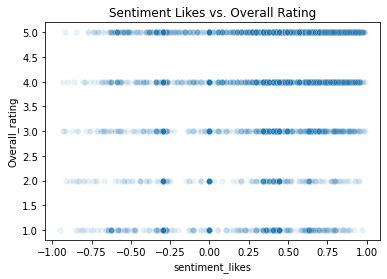

In [12]:
sns.scatterplot(x='sentiment_likes', y='Overall_rating', data=clean_df_tata, alpha=0.1)
plt.title('Sentiment Likes vs. Overall Rating')

Text(0.5, 1.0, 'Sentiment Dislikes vs. Overall Rating')

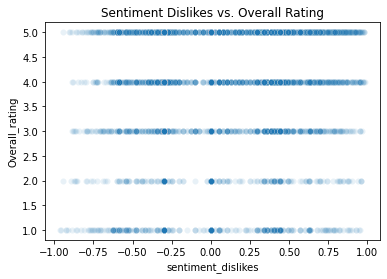

In [13]:
sns.scatterplot(x='sentiment_dislikes', y='Overall_rating', data=clean_df_tata, alpha=0.1)
plt.title('Sentiment Dislikes vs. Overall Rating')

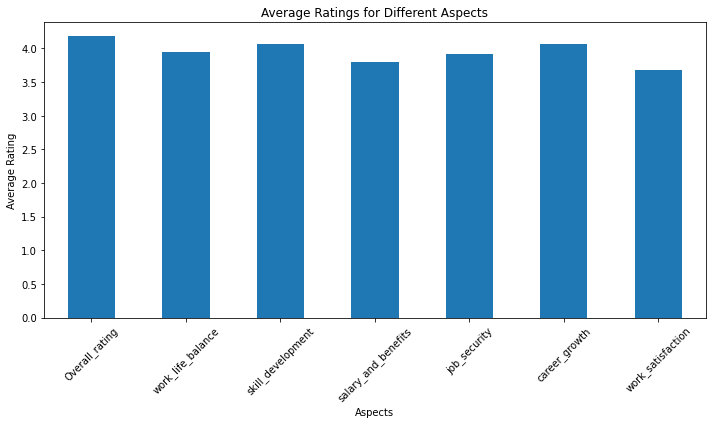

In [14]:
# calculate the average ratings for different aspects
rating_columns = ['Overall_rating', 'work_life_balance', 'skill_development', 'salary_and_benefits',
                  'job_security', 'career_growth', 'work_satisfaction']

average_ratings = clean_df_tata[rating_columns].mean()

# plot the bar chart
plt.figure(figsize=(10, 6))
average_ratings.plot(kind='bar')

# titles and labels
plt.title('Average Ratings for Different Aspects')
plt.xlabel('Aspects')
plt.ylabel('Average Rating')
plt.xticks(rotation=45)

# show bar chart
plt.tight_layout()
plt.show()

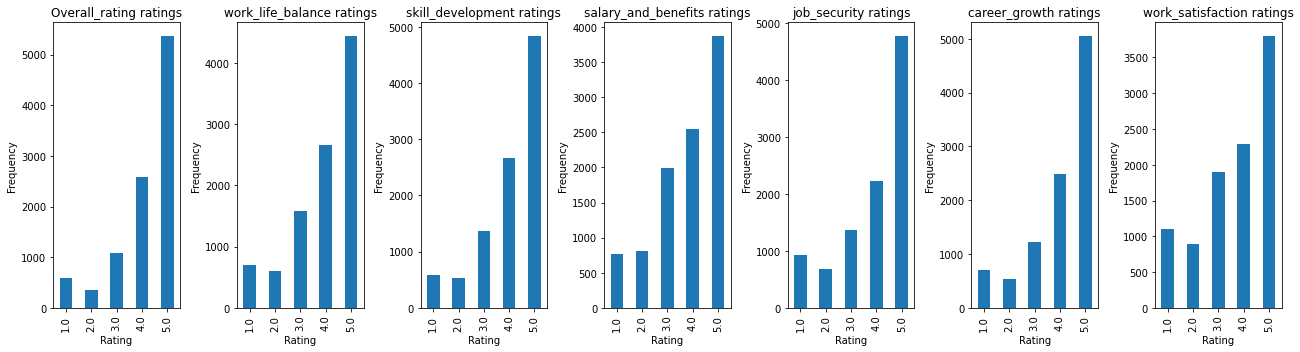

In [15]:
# create individual bar plots for each rating column
num_columns = len(rating_columns)
fig, axes = plt.subplots(nrows=1, ncols=num_columns, figsize=(18, 5))

# create a loop to make visualizations
for i, col in enumerate(rating_columns):
    ax = axes[i]
    clean_df_tata[col].value_counts().sort_index().plot(kind='bar', ax=ax)
    ax.set_title(f'{col} ratings')
    ax.set_xlabel('Rating')
    ax.set_ylabel('Frequency')

# show the plot
plt.tight_layout()
plt.show()

### Model Development, Evaluation, & Tuning/Optimization

In [16]:
# define the input features
x_features = ['work_life_balance', 'skill_development', 'salary_and_benefits',      
               'job_security', 'career_growth', 'work_satisfaction', 'sentiment_likes', 
               'sentiment_dislikes']

# partition the data
X   = clean_df_tata[x_features]              #get the input features 
y   = clean_df_tata['Overall_rating']        #get the target

X_train, X_test, y_train, y_test = train_test_split(X,              #the input features
                                                    y,              #the label
                                                    test_size=0.2,  #set aside 20% of the data as the test set
                                                    random_state=7, #reproduce the results
                                                    stratify=y      #preserve the distribution of the labels
                                                   )

#### Model 1: K-NN Regressor

In [17]:
# create a K-NN Regressor
knn_reg = KNeighborsRegressor()

# fit the model to the training data
knn_reg.fit(X_train, y_train)

# make predictions on the test set
y_pred = knn_reg.predict(X_test)

# evaluate the model
mse = round(mean_squared_error(y_test, y_pred), 2)
print(f'Mean Squared Error: {mse}')


Mean Squared Error: 0.92


In [18]:
# setup the parameter grid to try values of n_neighbors = 5 or 7
params = {'n_neighbors': [5, 7]}

# initialize Grid Search with Cross Validation and return the training score
knn_grid = GridSearchCV(estimator = knn_reg, param_grid = params, cv=5, scoring='neg_mean_squared_error', 
                        return_train_score = True)
knn_grid.fit(X_train, y_train)

print('The best model/parameters are: ', knn_grid.best_params_)                    #print the best parameters
print('The best score that was obtained is: ' , round(knn_grid.best_score_, 2))    #print the best score


The best model/parameters are:  {'n_neighbors': 7}
The best score that was obtained is:  -0.86


#### Model 2: Random Forest Regressor

In [19]:
# create a RandomForestRegressor
rf_reg = RandomForestRegressor(random_state=7)

# fit the model to the training data
rf_reg.fit(X_train, y_train)

# make predictions on the test set
y_pred = rf_reg.predict(X_test)

# evaluate the model
mse = round(mean_squared_error(y_test, y_pred), 2)
print(f'Mean Squared Error: {mse}')


Mean Squared Error: 0.88


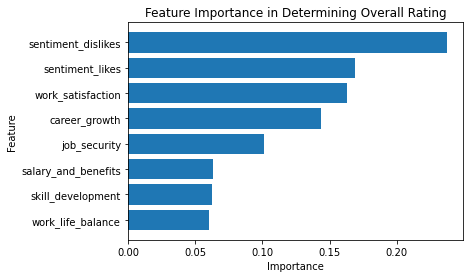

In [20]:
# plot feature importances
feat_list = clean_df_tata[x_features].columns
feat_import = rf_reg.feature_importances_

plt.barh(feat_list, sorted(feat_import))
plt.title('Feature Importance in Determining Overall Rating')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


In [21]:
# setup the parameter grid to try values of n_estimators ranging from 50 to 100
params = {'n_estimators': [50, 100, 200]}

# initialize Grid Search with Cross Validation and return the training score
rf_grid = GridSearchCV(estimator = rf_reg, param_grid = params, cv=5, scoring='neg_mean_squared_error', 
                       return_train_score = True)
rf_grid.fit(X_train, y_train)

print('The best model/parameters are: ', rf_grid.best_params_)                    #print the best parameters
print('The best score that was obtained is: ' , round(rf_grid.best_score_, 2))    #print the best score


The best model/parameters are:  {'n_estimators': 200}
The best score that was obtained is:  -0.87


#### Model 3: Support Vector Regressor

In [22]:
# normalize the numeric features
scaler = StandardScaler()
scaler.fit(X_train[x_features])

# scale the training data
X_train[x_features] = scaler.transform(X_train[x_features]) 

In [23]:
# initialize the regressor
svm = SVR()

# fit the model to the training data
svm.fit(X_train, y_train) 

# scale the test data
X_test[x_features] = scaler.transform(X_test[x_features])

# make predictions on the test set
y_pred = svm.predict(X_test)

# evaluate the model
mse = round(mean_squared_error(y_test, y_pred), 2)
print(f'Mean Squared Error: {mse}')


Mean Squared Error: 0.88


In [24]:
# setup the parameter grid to try values of c ranging from 1 to 5, and values for gamma = 1.
params = {'C': np.arange(1, 5),
          'gamma': np.arange(1)}

# initialize Grid Search with Cross Validation and return the training score
svm_grid = GridSearchCV(estimator = svm, param_grid = params, cv=5, scoring='neg_mean_squared_error', 
                        return_train_score = True)
svm_grid.fit(X_train, y_train)

print('The best model/parameters are: ', svm_grid.best_params_)                    #print the best parameters
print('The best score that was obtained is: ' , round(svm_grid.best_score_, 2))    #print the best score


The best model/parameters are:  {'C': 1, 'gamma': 0}
The best score that was obtained is:  -1.81
